In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

import os
import pickle
import re

import sklearn.ensemble as ske
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta

import json
import plotly.plotly as py
from plotly.graph_objs import *

from fuzzywuzzy import fuzz

/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Plot Stations Map

In [2]:
# Load Stations Data
station_info_path = '/home/cneiderer/Metis/boston_bike_data/station_data'
stations1_file = 'Hubway_Stations_2011_2016.csv'
stations2_file = 'Hubway_Stations_as_of_July_2017.csv'

stations1_df = pd.read_csv(os.path.join(station_info_path, stations1_file))
stations2_df = pd.read_csv(os.path.join(station_info_path, stations2_file))

# Standardize column names and order
stations1_df = stations1_df[stations2_df.columns]
stations1_df.columns = ['StationID', 'StationName', 'Lat', 'Lon', 'City', 'NumDocks']
stations1_df = stations1_df.sort_values('StationID', axis=0)

stations2_df = stations2_df.sort_values('Station ID', axis=0)
stations2_df.columns = ['StationID', 'StationName', 'Lat', 'Lon', 'City', 'NumDocks']
stations2_df = stations2_df.sort_values('StationID', axis=0)

In [3]:
# Combine station data into single DF
stations_df = pd.concat([stations1_df, stations2_df], axis=0)
# Remove duplicate rows
stations_df = stations_df[~stations_df.duplicated()]

# Compile all the names used to refer to each station ID
station_name_map = {}
for sid in set(stations_df.StationID):
    station_name_map[sid] = list(set(stations_df[stations_df.StationID == sid].StationName))
    
    # Designate a single name to be used to refer to each station ID
station_names = {}
for key, val in station_name_map.items():
    if len(val) > 1:
        val = val[1]
    else:
        val = val[0]
    station_names[key] = val
# Convert to dataframe    
station_names = pd.DataFrame.from_dict(station_names, 'index').reset_index()    
station_names.columns = ['StationID', 'StationName']
# Merge designated names back into combined stations DF
stations_df = station_names.merge(stations_df[['StationID', 'Lat', 'Lon', 'City', 'NumDocks']], on='StationID', how='left')
stations_df = stations_df[~stations_df.duplicated()].reset_index(drop=True)

In [4]:
# Create Interactive Map
credentials = json.load(open('/home/cneiderer/.mapbox/.credentials'))
mapbox_access_token = credentials['public_token']

data = Data([
    Scattermapbox(
        lat=stations_df.Lat,
        lon=stations_df.Lon,
        mode='markers',
        marker=Marker(
            color='red',
            size=10,
            opacity=0.7
        ),
        text=stations_df.StationName,
    )    
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    width=1200,
    height=800,
    margin=Margin(
        l=25,
        r=25,
        b=25,
        t=25,
        pad=4
    ),
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=42.361769, 
            lon=-71.078249 #-71.0589
        ),
        pitch=0,
        zoom=11.5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

### Load Trip Data

In [5]:
# Load new df
with open('new_clean.pkl', 'rb') as f:
    df = pickle.load(f)

# Change user type description
def remap_usertype(df):
    usertype_map = {'Subscriber': 'Member', 'Customer': 'Casual'}
    df.UserType = df.UserType.map(usertype_map)
    return df
df = remap_usertype(df)

# Sort by start time
df = df.sort_values('StartTime')
df = df.reset_index(drop=True)

In [6]:
df.head()

,Duration,StartTime,StopTime,StartID,StartName,StartLat,StartLon,StopID,StopName,StopLat,StopLon,BikeID,UserType,BirthYear,Gender
0,542,2015-01-01 00:21:44,2015-01-01 00:30:47,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,Member,1984,Male
1,438,2015-01-01 00:27:03,2015-01-01 00:34:21,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,648,Member,1985,Male
2,254,2015-01-01 00:31:31,2015-01-01 00:35:46,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,555,Member,1974,Male
3,432,2015-01-01 00:53:46,2015-01-01 01:00:58,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1307,Member,1987,Male
4,735,2015-01-01 01:07:06,2015-01-01 01:19:21,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,177,Casual,1986,Female


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3731291 entries, 0 to 3731290
Data columns (total 15 columns):
Duration     int64
StartTime    datetime64[ns]
StopTime     datetime64[ns]
StartID      int64
StartName    object
StartLat     float64
StartLon     float64
StopID       int64
StopName     object
StopLat      float64
StopLon      float64
BikeID       int64
UserType     object
BirthYear    object
Gender       object
dtypes: datetime64[ns](2), float64(4), int64(4), object(5)
memory usage: 427.0+ MB


In [8]:
print('Min Time: %s, Max Time: %s' % (str(df.StartTime.min()), str(df.StopTime.max())))
print('Delta: %s' % str(df.StopTime.max() - df.StartTime.min()))

Min Time: 2015-01-01 00:21:44, Max Time: 2018-03-12 14:42:50
Delta: 1166 days 14:21:06


### Feature Engineering

In [22]:
# Start Features
df['StartYear'] = df.StartTime.dt.year
df['StartMonth'] = df.StartTime.dt.month
df['StartWeek'] = df.StartTime.dt.week
df['StartDay'] = df.StartTime.dt.day
df['StartHour'] = df.StartTime.dt.hour
df['StartQuarter'] = df.StartTime.dt.quarter
df['StartDayOfWeek'] = df.StartTime.dt.dayofweek

# Stop Features
df['StopYear'] = df.StopTime.dt.year
df['StopMonth'] = df.StopTime.dt.month
df['StopWeek'] = df.StopTime.dt.week
df['StopDay'] = df.StopTime.dt.day
df['StopHour'] = df.StopTime.dt.hour
df['StopQuarter'] = df.StopTime.dt.quarter
df['StopDayOfWeek'] = df.StopTime.dt.dayofweek

In [23]:
df.sample(10)

,Duration,StartTime,StopTime,StartID,StartName,StartLat,StartLon,StopID,StopName,StopLat,StopLon,BikeID,UserType,BirthYear,Gender,StartYear,StartMonth,StartWeek,StartDay,StartQuarter,StartDayOfWeek,StopYear,StopMonth,StopWeek,StopDay,StopQuarter,StopDayOfWeek,StartHour,StopHour
533243,94,2015-07-29 16:26:06,2015-07-29 16:27:41,13,Boston Medical Center - East Concord at Harri...,42.336437,-71.073089,39,Washington St. at Rutland St.,42.338623,-71.074182,592,Member,1987,Male,2015,7,31,29,3,2,2015,7,31,29,3,2,16,16
1271292,3069,2016-04-30 03:17:58,2016-04-30 04:09:08,178,MIT Pacific St at Purrington St,42.359573,-71.101295,46,Christian Science Plaza,42.343864,-71.085918,418,Member,NaN,Unknown,2016,4,17,30,2,5,2016,4,17,30,2,5,3,4
1180910,2256,2016-03-26 21:43:12,2016-03-26 22:20:48,81,Boylston St / Washington St,42.352409,-71.062679,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,508,Member,NaN,Unknown,2016,3,12,26,1,5,2016,3,12,26,1,5,21,22
2658145,972,2017-06-11 13:58:45,2017-06-11 14:14:58,17,Soldiers Field Park - 111 Western Ave,42.365064,-71.119233,70,Harvard Kennedy School at Bennett St / Eliot St,42.371992,-71.122270,1774,Member,1988,Male,2017,6,23,11,2,6,2017,6,23,11,2,6,13,14
2861862,240,2017-07-17 16:01:07,2017-07-17 16:05:07,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,179,MIT Vassar St,42.355601,-71.103945,1002,Member,1987,Male,2017,7,29,17,3,0,2017,7,29,17,3,0,16,16
3342385,4183,2017-10-07 15:23:58,2017-10-07 16:33:41,9,Commonwealth Ave at Buick St,42.350622,-71.112882,218,Watermark Seaport - Boston Wharf Rd at Seaport...,42.351586,-71.045693,1612,Casual,NaN,Unknown,2017,10,40,7,4,5,2017,10,40,7,4,5,15,16
3070727,210,2017-08-20 21:22:17,2017-08-20 21:25:48,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,139,Dana Park,42.361780,-71.108100,488,Member,1978,Male,2017,8,33,20,3,6,2017,8,33,20,3,6,21,21
320054,1488,2015-06-20 09:40:44,2015-06-20 10:05:32,132,Summer St at Cutter St,42.394002,-71.120406,15,Harvard Real Estate - Brighton Mills - 370 Wes...,42.361667,-71.138020,844,Casual,1992,Male,2015,6,25,20,2,5,2015,6,25,20,2,5,9,10
1883474,371,2016-08-27 11:45:36,2016-08-27 11:51:47,79,Beacon St at Washington / Kirkland,42.378420,-71.105668,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,1835,Member,1982,Male,2016,8,34,27,3,5,2016,8,34,27,3,5,11,11
2134858,1256,2016-10-13 19:52:24,2016-10-13 20:13:20,6,Cambridge St. at Joy St.,42.361174,-71.065142,134,New Balance Store - Boylston at Dartmouth,42.350413,-71.076550,1773,Member,1984,Male,2016,10,41,13,4,3,2016,10,41,13,4,3,19,20


### Split the Data

In [49]:
# Split df into start and stop
def find_columns(df, status):
    columns = ['Duration', 'BikeID', 'UserType', 'BirthYear']
    for col in df.columns:
        if len(re.findall(status+'\w*', col)) > 0:
            columns.append(col)
    return columns      

start_df = df[find_columns(df, 'Start')]
stop_df = df[find_columns(df, 'Stop')]

In [50]:
def rename_columns(df, status):
    columns = [''.join(x.split(status)) for x in df.columns]
    return columns

start_df.columns = rename_columns(start_df, 'Start')
stop_df.columns = rename_columns(stop_df, 'Stop')

In [51]:
start_df.head()

,Duration,BikeID,UserType,BirthYear,Time,ID,Name,Lat,Lon,Year,Month,Week,Day,Quarter,DayOfWeek,Hour
0,542,277,Member,1984,2015-01-01 00:21:44,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,1,3,0
1,438,648,Member,1985,2015-01-01 00:27:03,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,2015,1,1,1,1,3,0
2,254,555,Member,1974,2015-01-01 00:31:31,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,1,3,0
3,432,1307,Member,1987,2015-01-01 00:53:46,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,1,3,0
4,735,177,Casual,1986,2015-01-01 01:07:06,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,2015,1,1,1,1,3,1


In [52]:
stop_df.head()

,Duration,BikeID,UserType,BirthYear,Time,ID,Name,Lat,Lon,Year,Month,Week,Day,Quarter,DayOfWeek,Hour
0,542,277,Member,1984,2015-01-01 00:30:47,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,2015,1,1,1,1,3,0
1,438,648,Member,1985,2015-01-01 00:34:21,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,2015,1,1,1,1,3,0
2,254,555,Member,1974,2015-01-01 00:35:46,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2015,1,1,1,1,3,0
3,432,1307,Member,1987,2015-01-01 01:00:58,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,2015,1,1,1,1,3,1
4,735,177,Casual,1986,2015-01-01 01:19:21,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,2015,1,1,1,1,3,1


### Start Time Analysis

In [53]:
plt.style.use('default')

In [54]:
# Set index to start time and sort
start_df = start_df.set_index('Time')
start_df = start_df.sort_index()

# Subset on 2015-2017
start_df = start_df[start_df.index < dt.strptime("2018-01-01", "%Y-%m-%d")]

In [55]:
start_df.head()

,Duration,BikeID,UserType,BirthYear,ID,Name,Lat,Lon,Year,Month,Week,Day,Quarter,DayOfWeek,Hour
Time,,,,,,,,,,,,,,,
2015-01-01 00:21:44,542,277,Member,1984,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,1,3,0
2015-01-01 00:27:03,438,648,Member,1985,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,2015,1,1,1,1,3,0
2015-01-01 00:31:31,254,555,Member,1974,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,1,3,0
2015-01-01 00:53:46,432,1307,Member,1987,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,1,3,0
2015-01-01 01:07:06,735,177,Casual,1986,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,2015,1,1,1,1,3,1


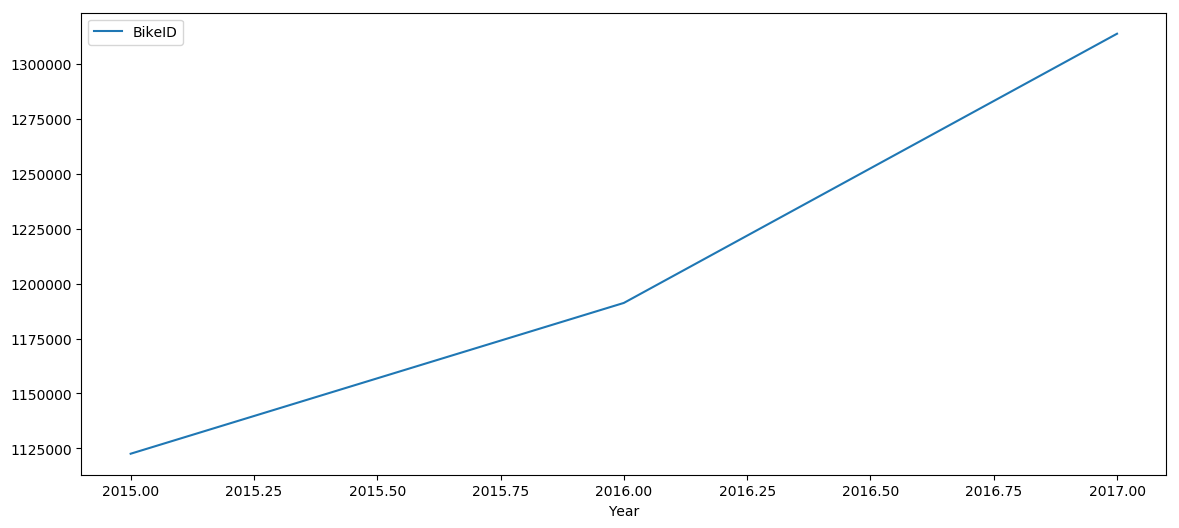

In [56]:
# Rides per Year
pt_year = start_df.pivot_table(index="Year", values="BikeID", aggfunc="count")
pt_year.plot(figsize=(14,6));

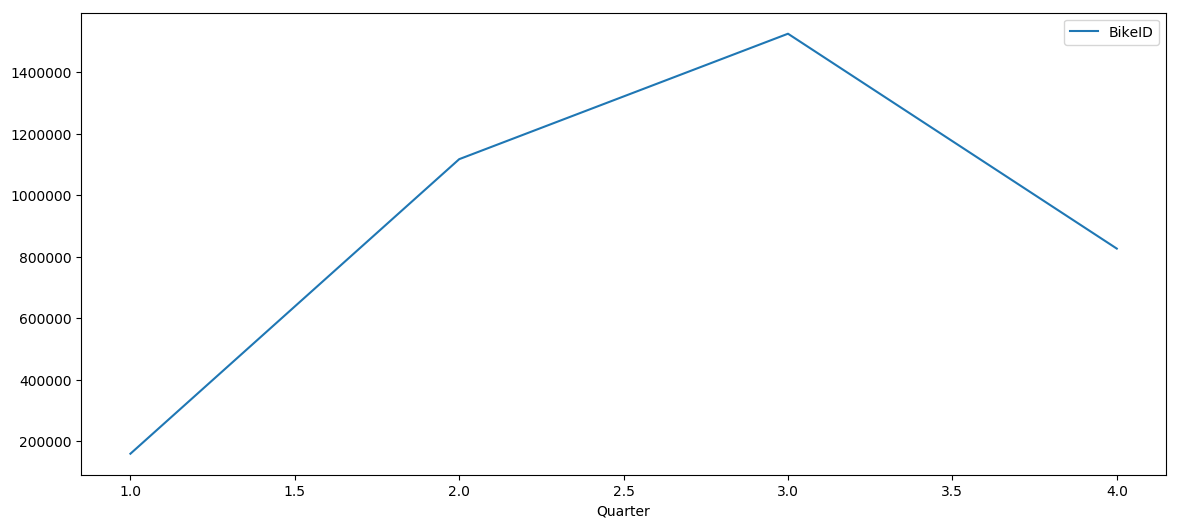

In [57]:
# Rides per Quarter
pt_quarter = start_df.pivot_table(index="Quarter", values="BikeID", aggfunc="count")
pt_quarter.plot(figsize=(14,6));

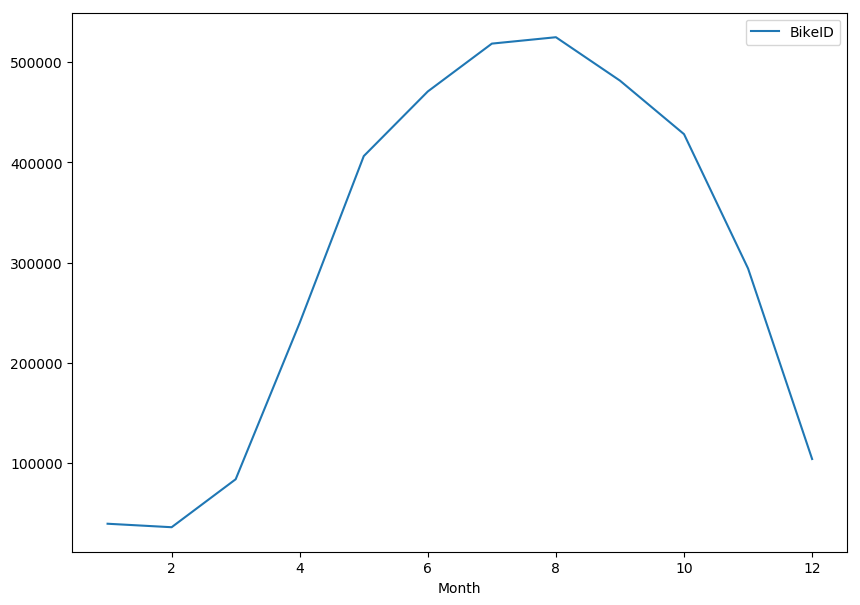

In [58]:
# Rides per Month
pt_month = start_df.pivot_table(index="Month", values="BikeID", aggfunc="count")
pt_month.plot(figsize=(10,7));

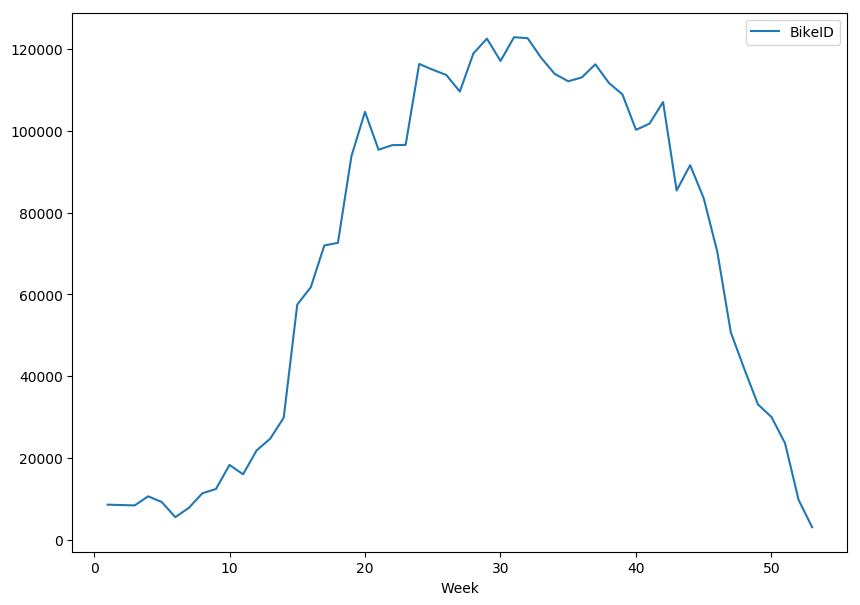

In [59]:
# Rides per Week
pt_week = start_df.pivot_table(index="Week", values="BikeID", aggfunc="count")
pt_week.plot(figsize=(10,7));

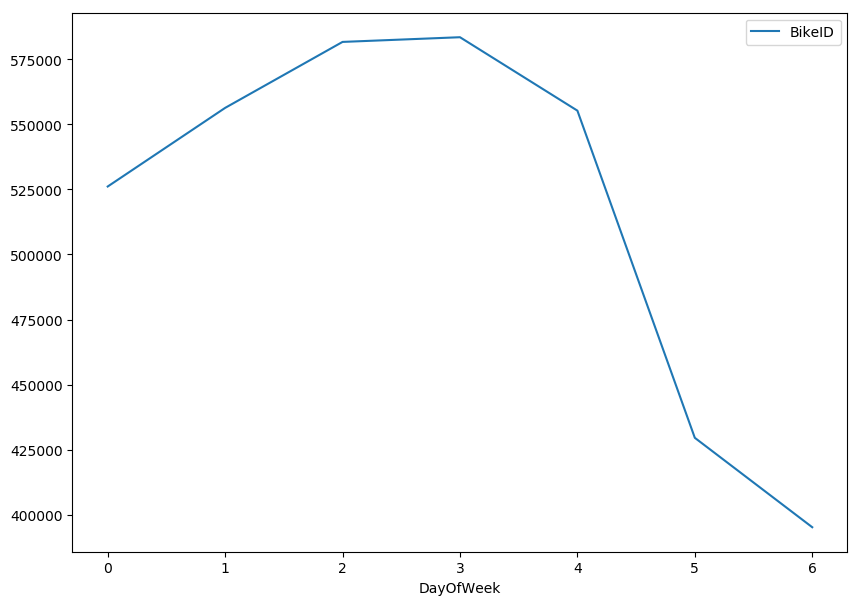

In [60]:
# Rides per Day 
pt_dayofweek = start_df.pivot_table(index="DayOfWeek", values="BikeID", aggfunc="count")
pt_dayofweek.plot(figsize=(10,7));

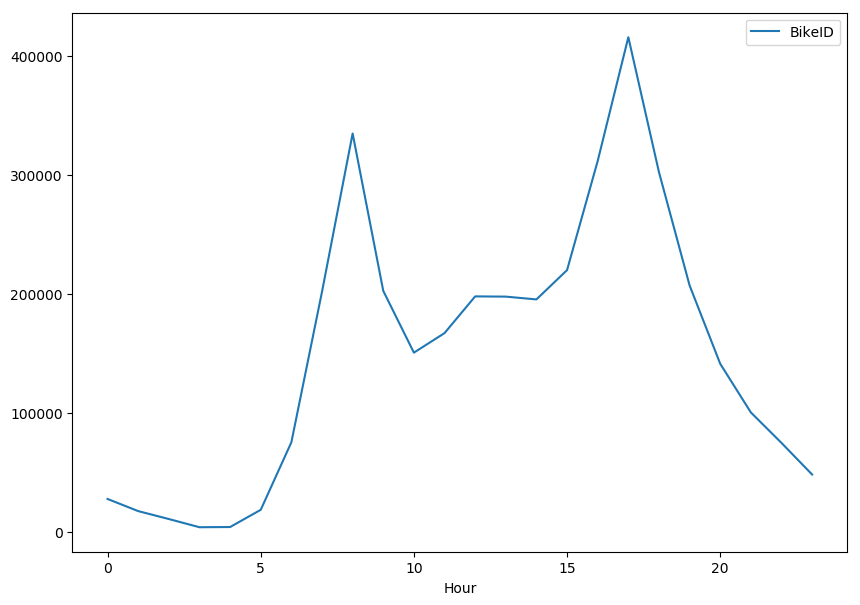

In [61]:
# Rides per Hr
pt_dayofweek = start_df.pivot_table(index="Hour", values="BikeID", aggfunc="count")
pt_dayofweek.plot(figsize=(10,7));

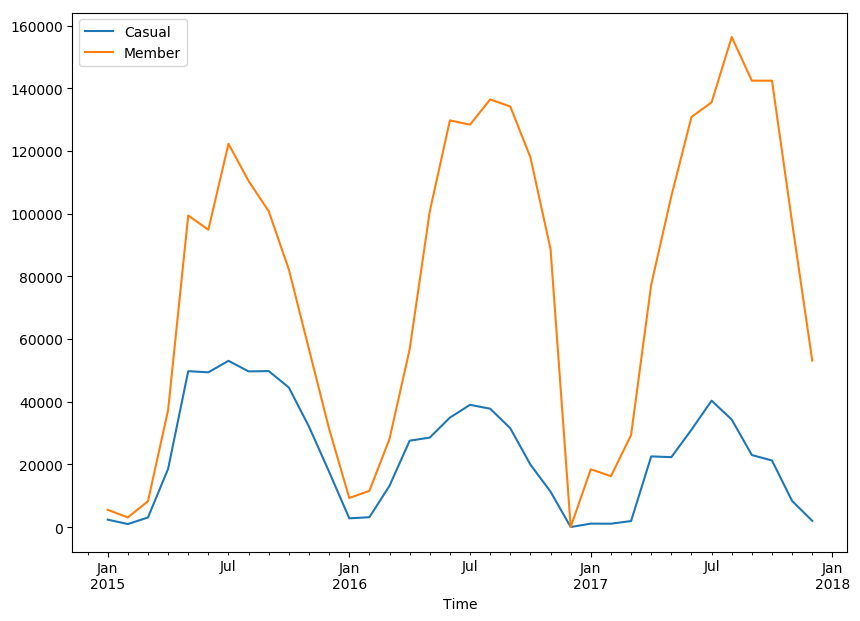

In [68]:
R_usertype_dayofweek = df_usertype.resample("M").sum()
R_usertype_dayofweek.plot(figsize=(10, 7));

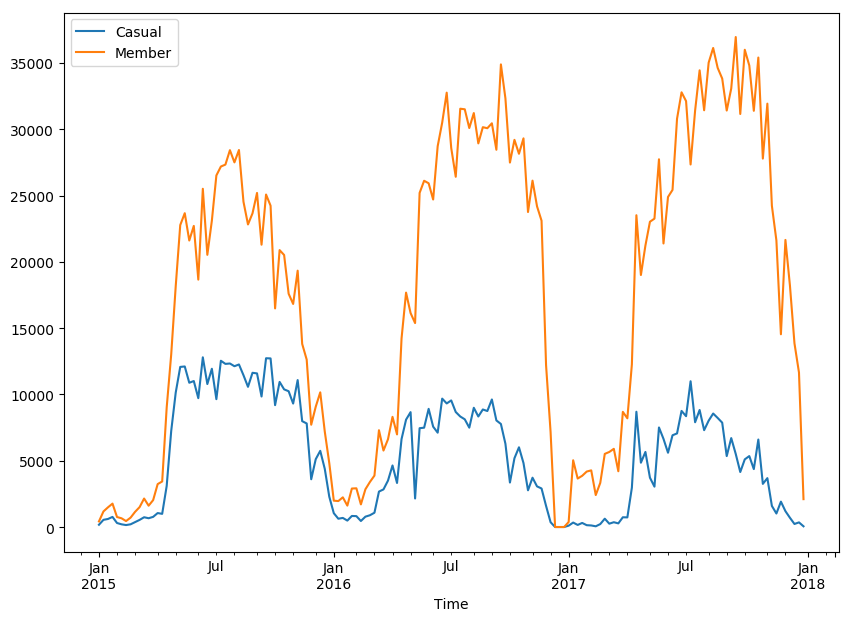

In [65]:
df_usertype = pd.get_dummies(start_df.UserType)

R_usertype_week = df_usertype.resample("W").sum()
R_usertype_week.plot(figsize=(10, 7));

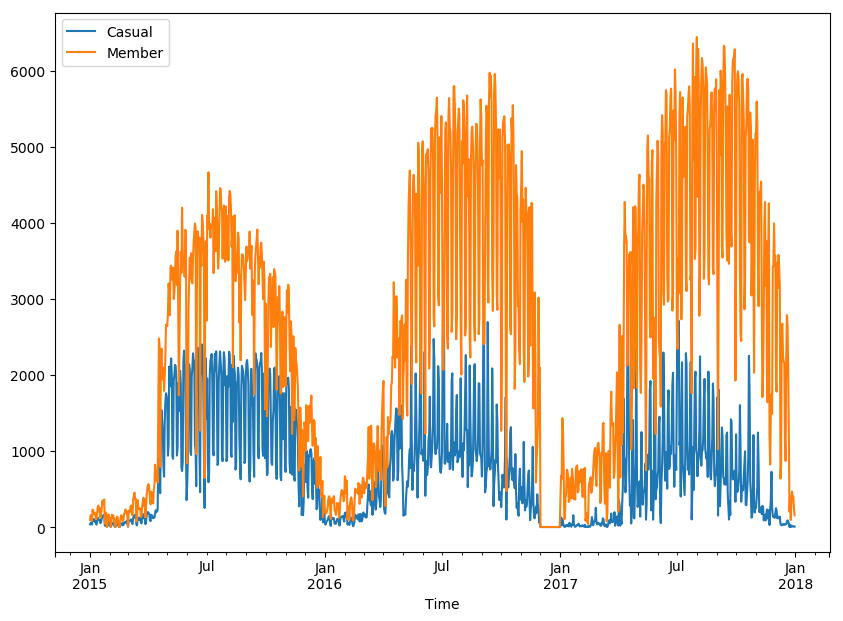

In [66]:
R_usertype_day = df_usertype.resample("D").sum()
R_usertype_day.plot(figsize=(10, 7));

### Autocorrelation

In [35]:
# resample all data to daily counts
R_day = start_df.BikeID.resample("D").count()
R_day.head(10)

Time
2015-01-01    127
2015-01-02    213
2015-01-03    142
2015-01-04    112
2015-01-05    337
2015-01-06    267
2015-01-07    296
2015-01-08    247
2015-01-09    275
2015-01-10    162
Freq: D, Name: BikeID, dtype: int64

In [36]:
R_day.shape

(1155,)

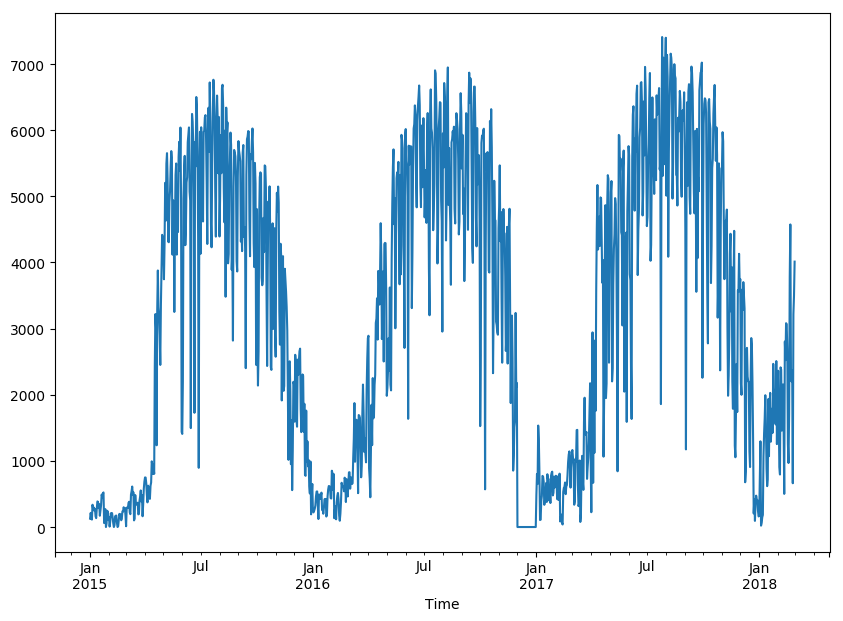

In [37]:
R_day.plot(figsize=(10,7));

In [38]:
# check autocorrelation for previous two weeks
for i in range(1,22):
    print(i, R_day.autocorr(lag=i))

1 0.897804794318
2 0.830121275241
3 0.808062082603
4 0.804130202759
5 0.813458924073
6 0.853408743797
7 0.874274673428
8 0.841484068551
9 0.792757499022
10 0.773171490835
11 0.775320220629
12 0.795279505712
13 0.825912246692
14 0.845787333421
15 0.805237177747
16 0.759597865025
17 0.743370672721
18 0.735018016256
19 0.747073745343
20 0.780901375422
21 0.800485966445


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



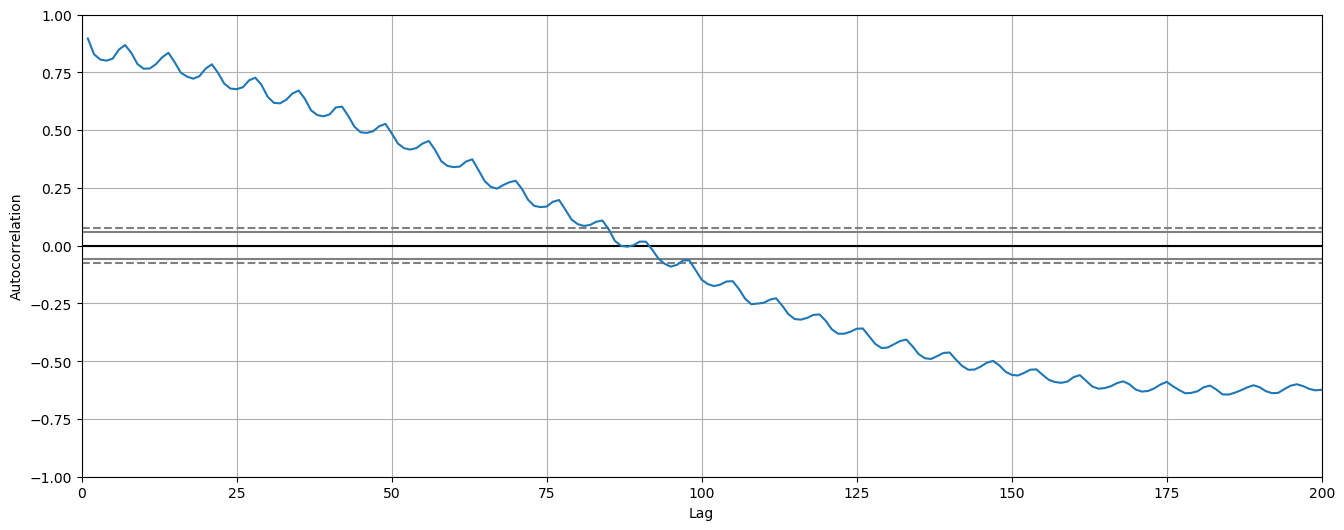

In [40]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(16,6))

autocorrelation_plot(R_day)
plt.xlim(0,200);

#plot shows high autocorrelation accross lags

### Weekly Autocorrelation

In [69]:
# resample all data to weekly counts
R_week = start_df.BikeID.resample("W").count()
R_week.head(10)

Time
2015-01-04     594
2015-01-11    1718
2015-01-18    2092
2015-01-25    2527
2015-02-01    1058
2015-02-08     862
2015-02-15     598
2015-02-22     910
2015-03-01    1513
2015-03-08    2038
Freq: W-SUN, Name: BikeID, dtype: int64

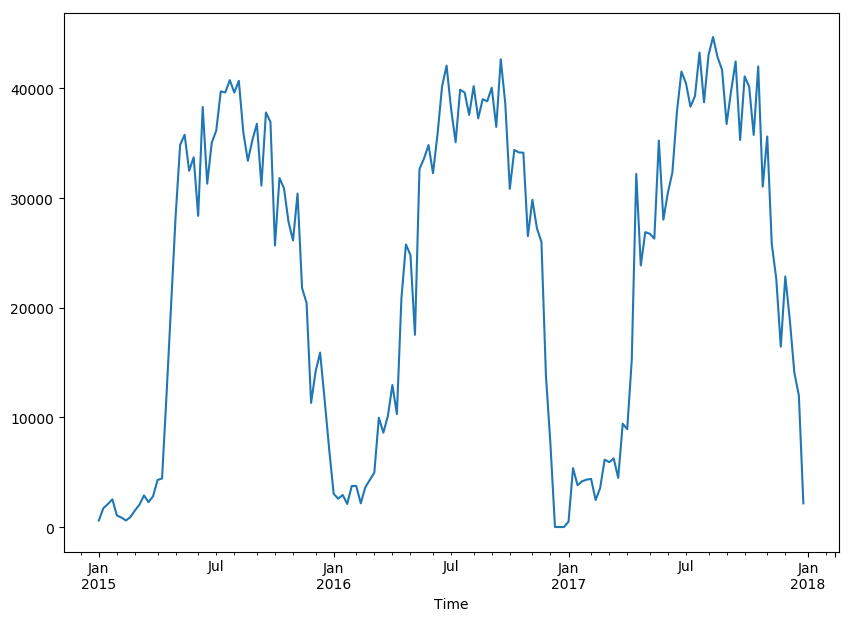

In [70]:
R_week.plot(figsize=(10, 7));

In [71]:
# check autocorrelation for previous 6 weeks
for i in range(1,6):
    print(i, R_week.autocorr(lag=i))

1 0.950244197492
2 0.91576352347
3 0.867562248618
4 0.812988836805
5 0.751509303509


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



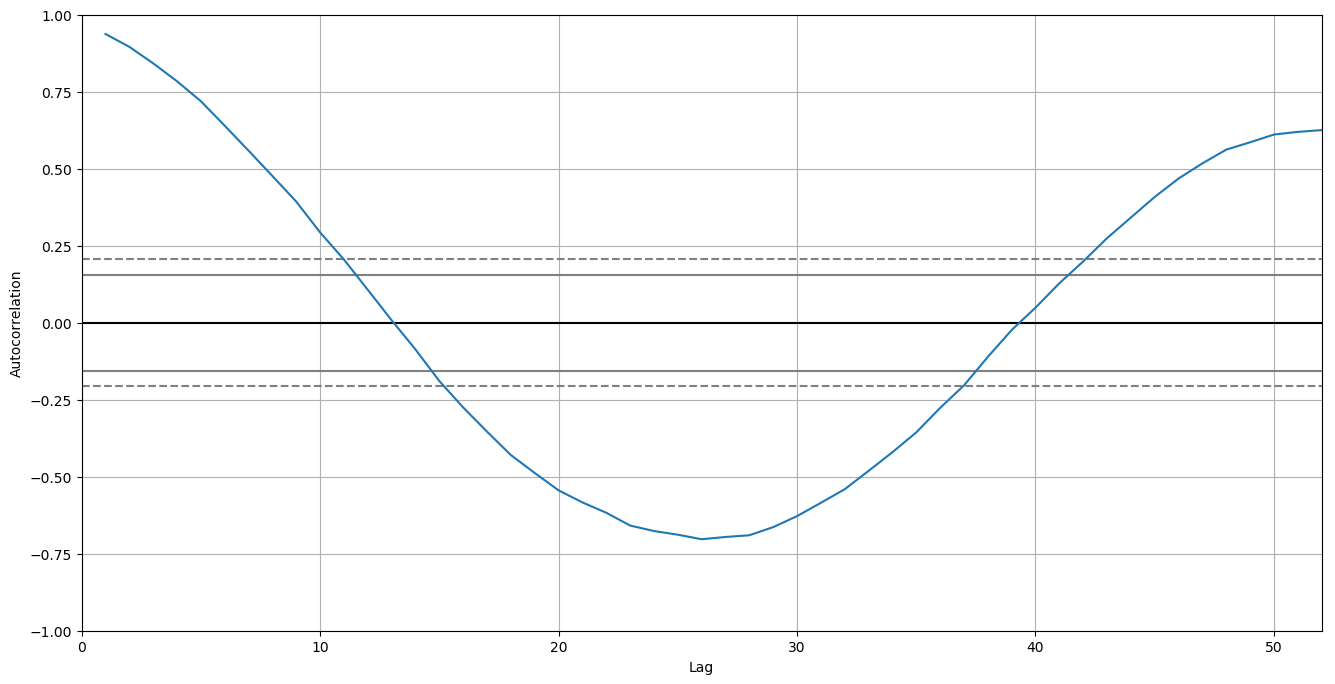

In [76]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(16, 8))

autocorrelation_plot(R_week)
plt.xlim(0,52);

#plot shows high autocorrelation accross lags

### Monthly Autocorrelation

In [73]:
# resample all data to montly counts
R_month = start_df.BikeID.resample("M").count()
R_month.head(10)

Time
2015-01-31      7840
2015-02-28      4020
2015-03-31     11270
2015-04-30     55843
2015-05-31    149143
2015-06-30    144232
2015-07-31    175321
2015-08-31    160065
2015-09-30    150516
2015-10-31    126656
Freq: M, Name: BikeID, dtype: int64

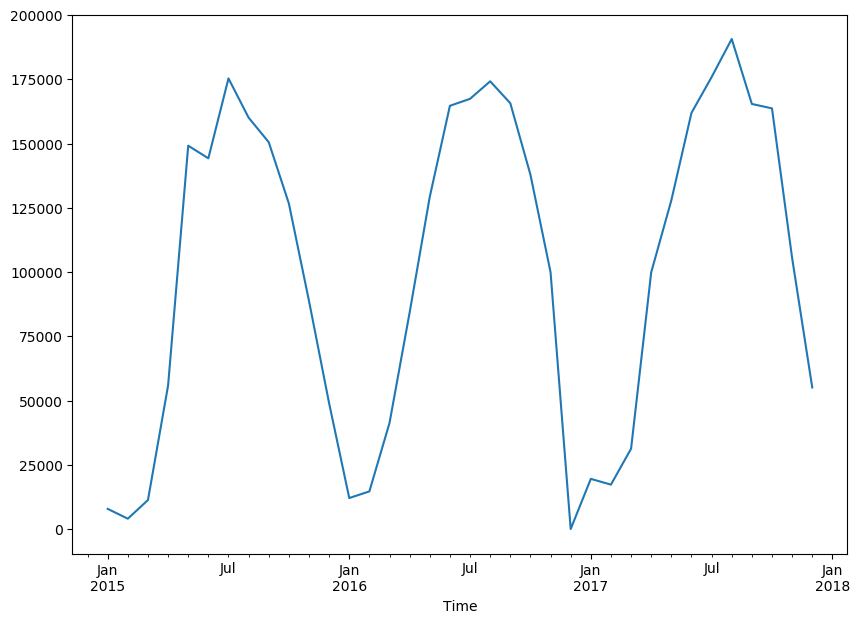

In [74]:
R_month.plot(figsize=(10,7));

In [75]:
# check autocorrelation for previous 6 months
for i in range(1,6):
    print(i, R_month.autocorr(lag=i))

1 0.821733896062
2 0.471999013229
3 0.00223865835859
4 -0.474754873998
5 -0.77446511979


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



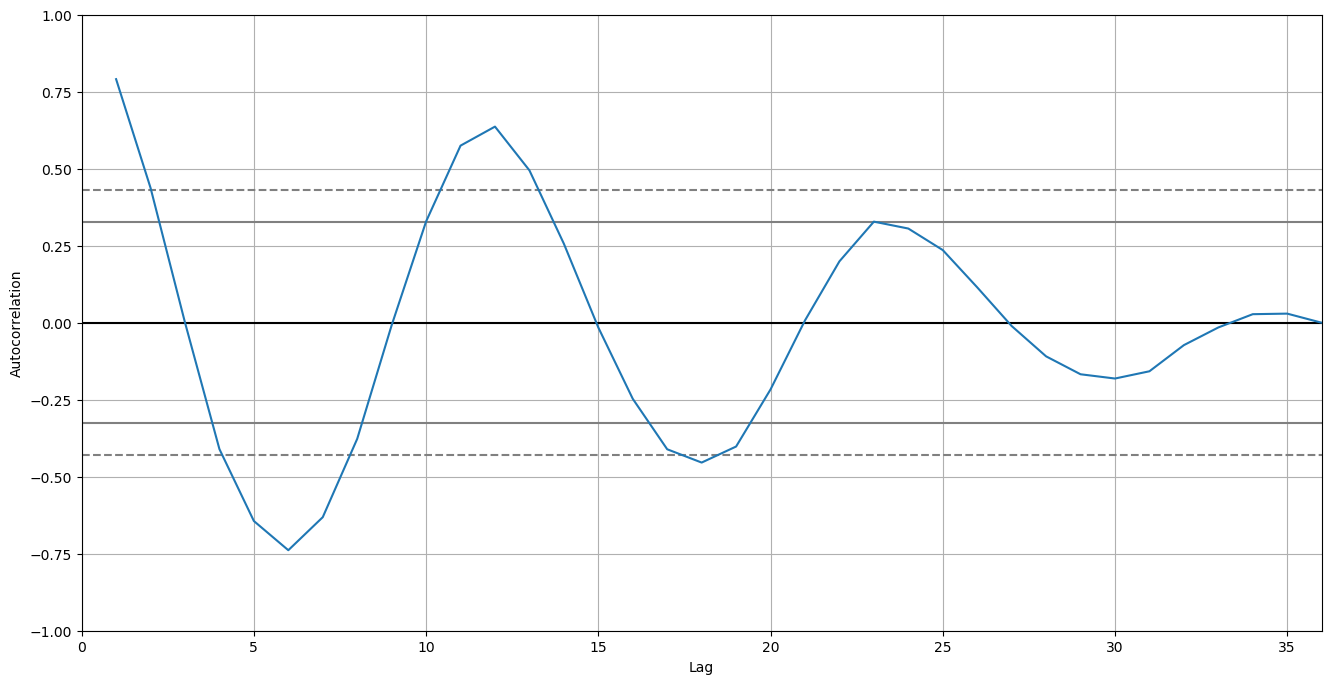

In [78]:

# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(16, 8))

autocorrelation_plot(R_month);
plt.xlim(0,36);

#plot shows high autocorrelation accross lags

### Autocorrelation by user type (member/subscriber)

In [79]:
start_df.UserType.value_counts()

Member    2798424
Casual     829119
Name: UserType, dtype: int64

In [80]:
# resample all data to daily counts
df_usertype = pd.get_dummies(start_df.UserType)

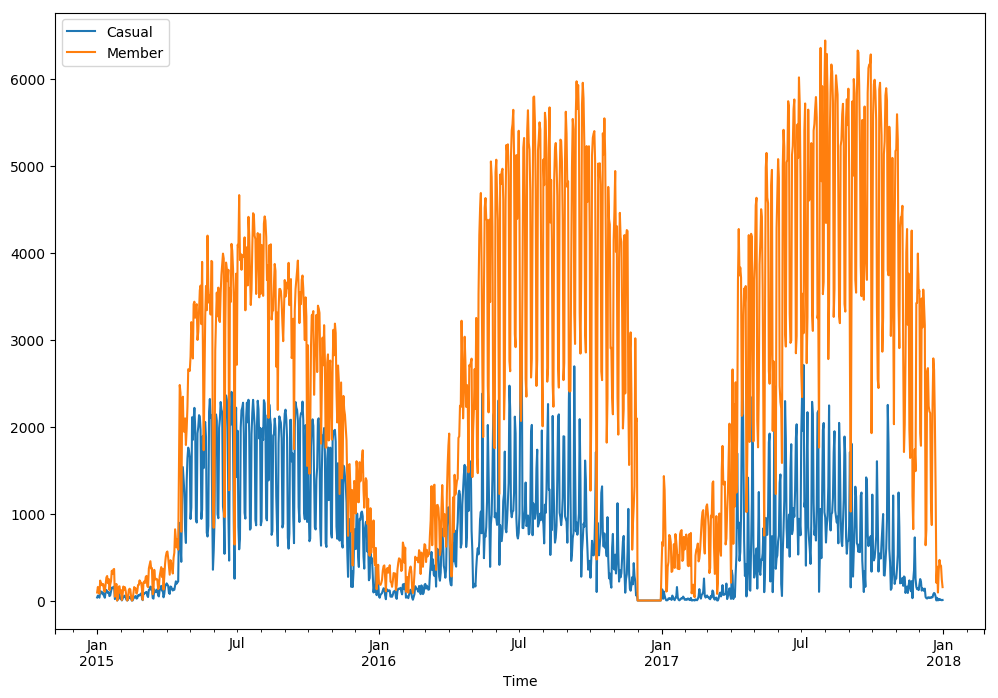

In [81]:
R_usertype_day = df_usertype.resample("D").sum()
R_usertype_day.plot(figsize=(12,8));

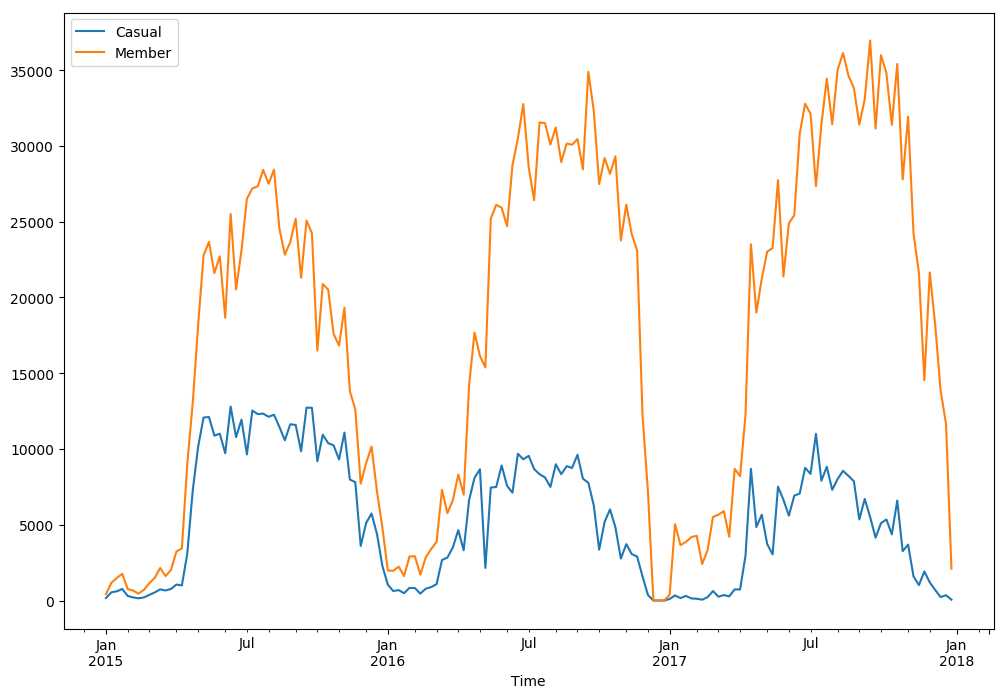

In [82]:
R_usertype_week = df_usertype.resample("W").sum()
R_usertype_week.plot(figsize=(12,8));

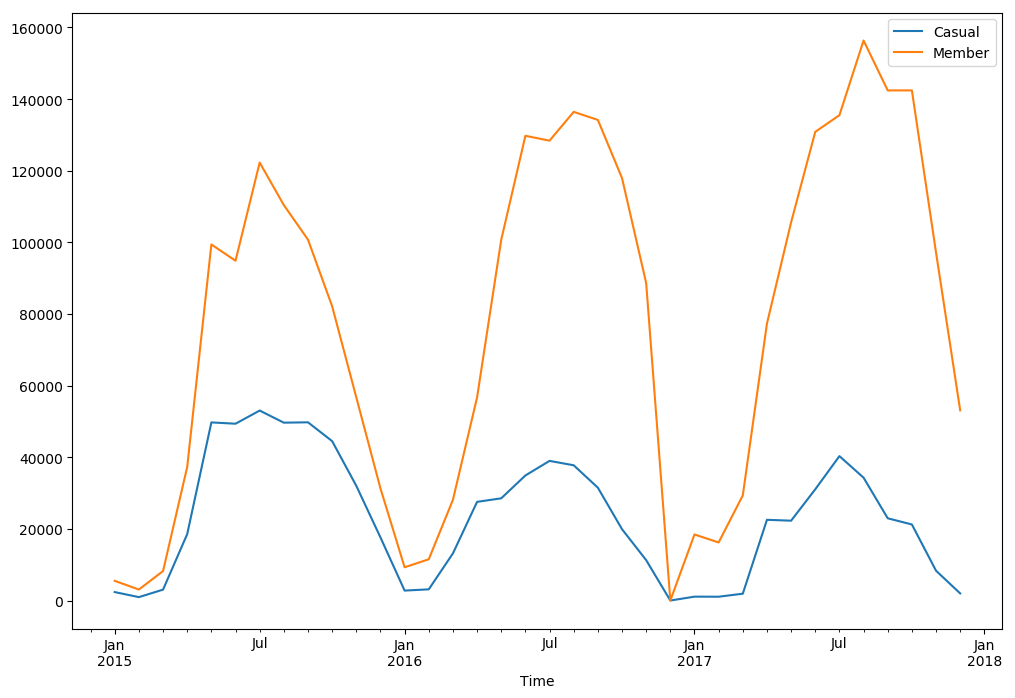

In [83]:
R_usertype_month = df_usertype.resample("M").sum()
R_usertype_month.plot(figsize=(12,8));

### Moving/Rolling Averages

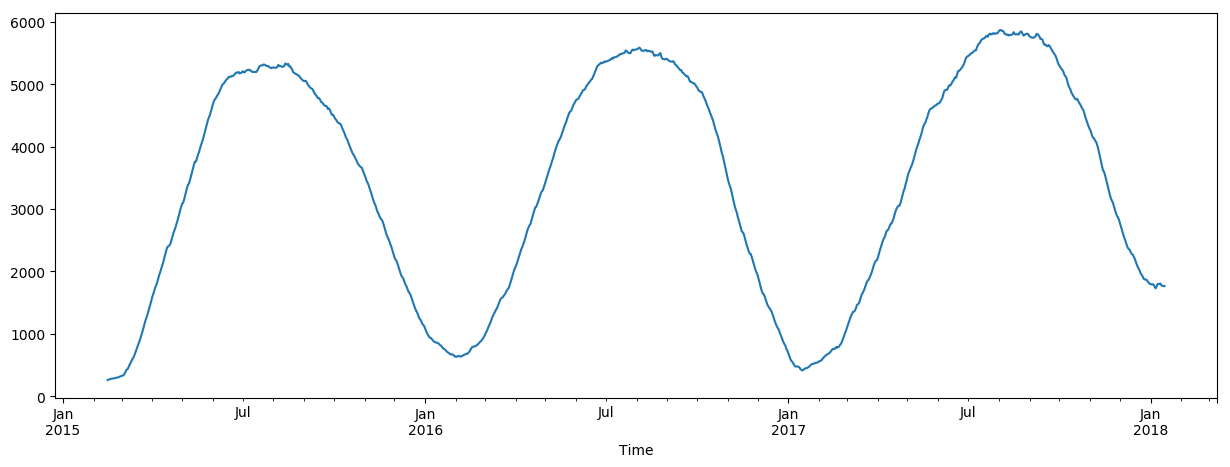

In [84]:
R_day.rolling(window=90, center=True).mean().plot(figsize=(15,5));

### Check Stationarity of Time Series
A time series is stationary is the mean and standard deviation is constant overtime. Most time series models assume the time series is stationary, so it's importat to check so we can account for this later.

Dickey-Fuller Test: This is a statistical check to test for stationarity. The null-hypothesis assumes that the time series is not stationary. If the p-value output is below our threshold (0.05) then we can reject the null- hypothesis and assume the time series is stationary.

In [85]:
from statsmodels.tsa.stattools import adfuller

In [86]:
def test_stationarity(timeseries):
    
    """
    ===============================
    This function tests the stationarity of a timeseries
    ===============================
    Input: time series dataframe or array
    ===============================
    Output: Dickey-Fuller Test and graph ploting rolloing mean and standard deviation
    ===============================
    """
    
    #Perform Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Dickey-Fuller Test:
Test Statistic                   -2.343336
p-value                           0.158372
#Lags Used                       23.000000
Number of Observations Used    1131.000000
Critical Value (1%)              -3.436145
Critical Value (5%)              -2.864099
Critical Value (10%)             -2.568132
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



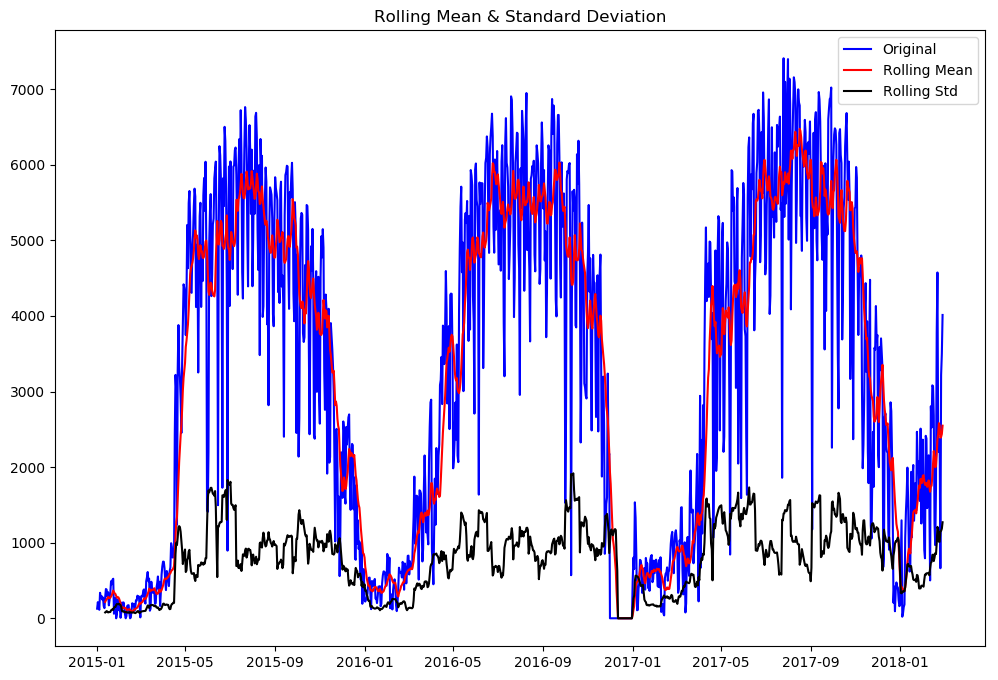

In [87]:
test_stationarity(R_day)

Results of Dickey-Fuller Test:
Test Statistic                  -5.254953
p-value                          0.000007
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



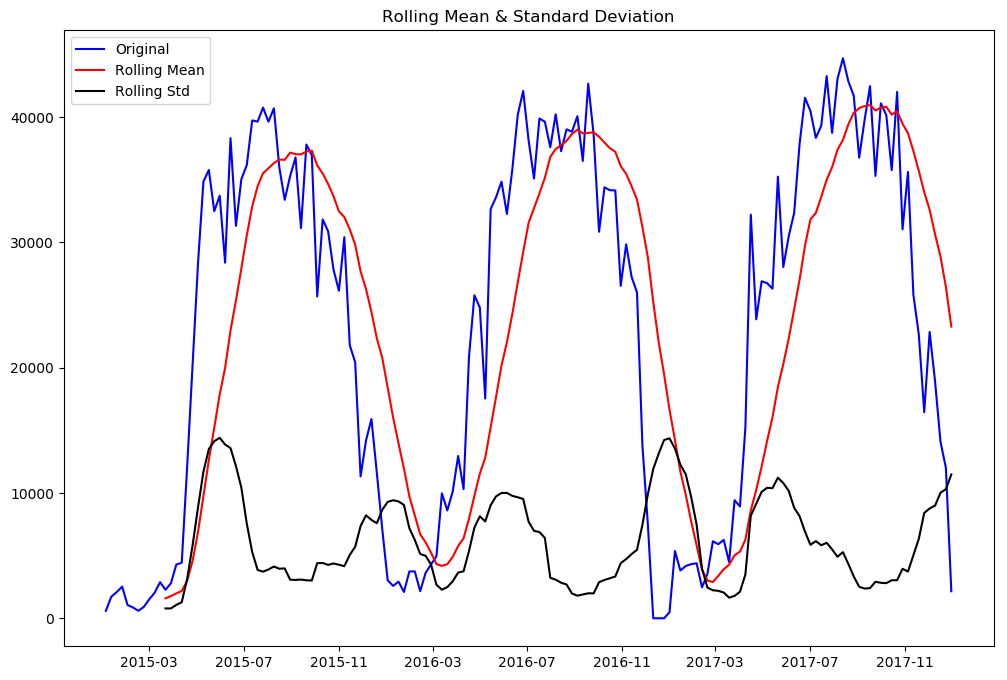

In [88]:
test_stationarity(R_week)

Results of Dickey-Fuller Test:
Test Statistic                 -4.786425
p-value                         0.000058
#Lags Used                      7.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



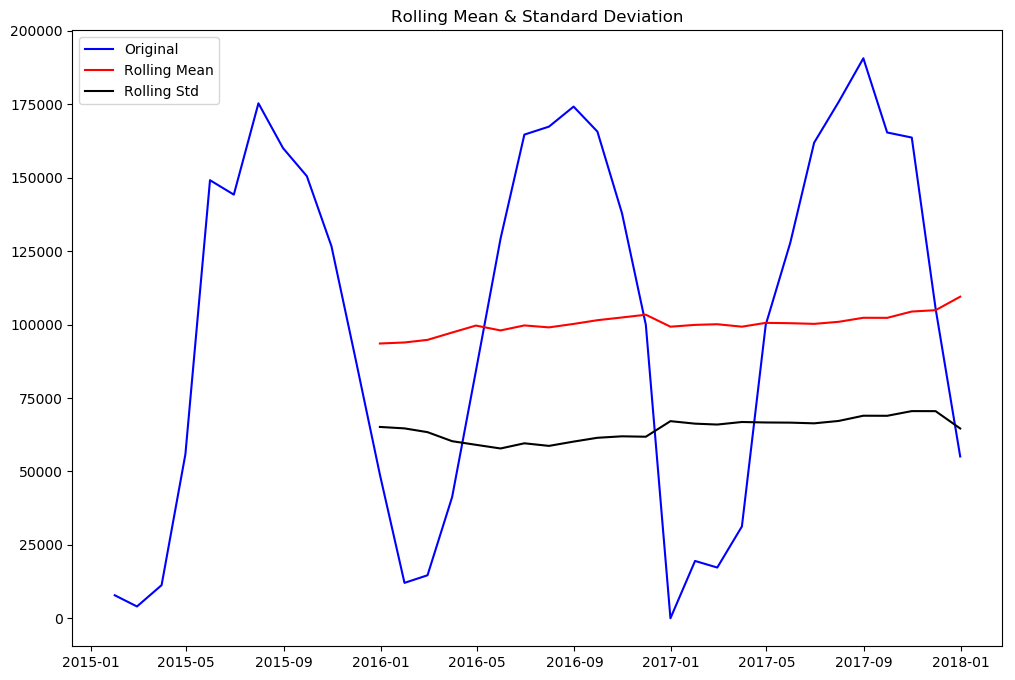

In [89]:
test_stationarity(R_month)

### Remove Stationarity
The Dickey-Fuller test shows that the data is not stationary. There is a clear seasonal trend with a growth in bike usage during the warmer summer months.

A SARIMA model assumes the data is stationary, so this needs to be removed before we run our model.

The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.

Results of Dickey-Fuller Test:
Test Statistic                   -2.343336
p-value                           0.158372
#Lags Used                       23.000000
Number of Observations Used    1131.000000
Critical Value (1%)              -3.436145
Critical Value (5%)              -2.864099
Critical Value (10%)             -2.568132
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



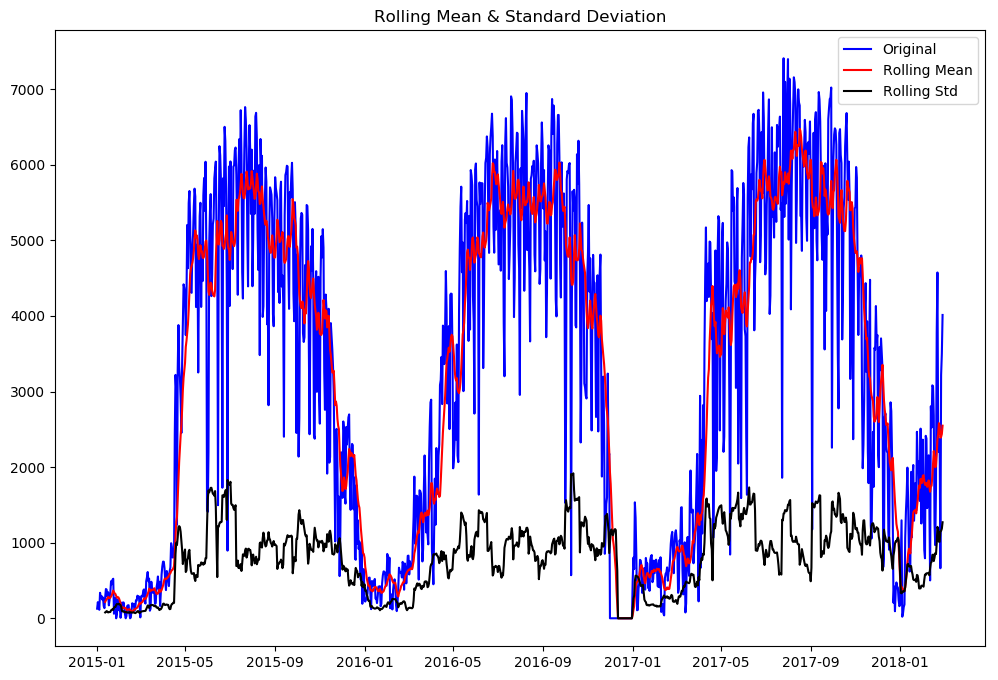

In [91]:
test_stationarity(R_day.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -7.059348e+00
p-value                        5.273001e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.131000e+03
Critical Value (1%)           -3.436145e+00
Critical Value (5%)           -2.864099e+00
Critical Value (10%)          -2.568132e+00
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



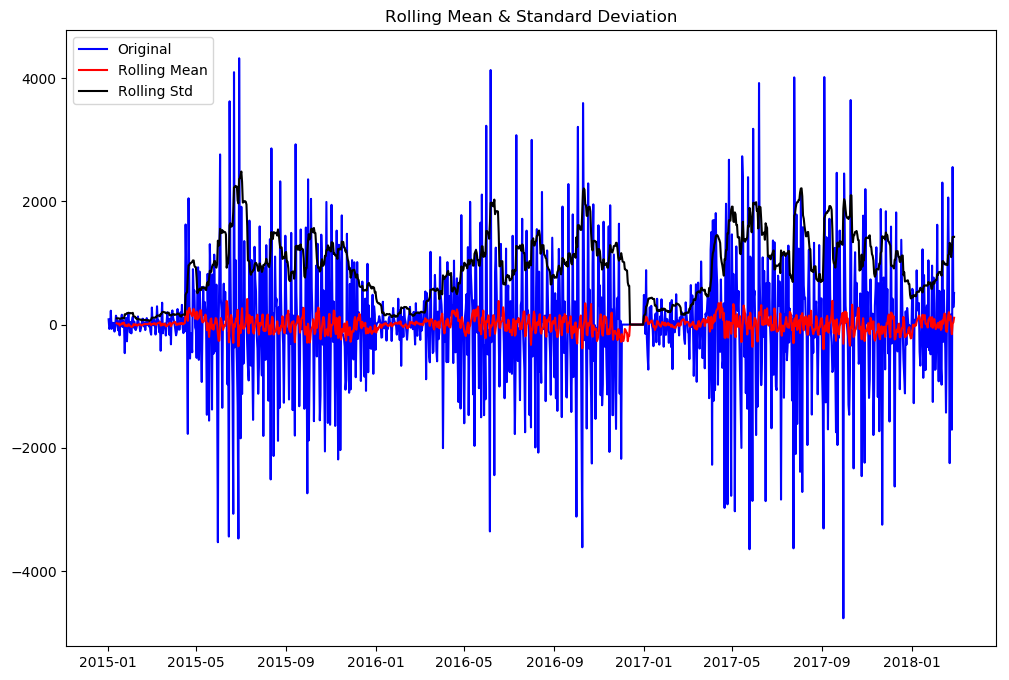

In [90]:
first_difference = R_day - R_day.shift(1)
first_difference
test_stationarity(first_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                   -3.717475
p-value                           0.003874
#Lags Used                       22.000000
Number of Observations Used    1102.000000
Critical Value (1%)              -3.436298
Critical Value (5%)              -2.864166
Critical Value (10%)             -2.568168
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



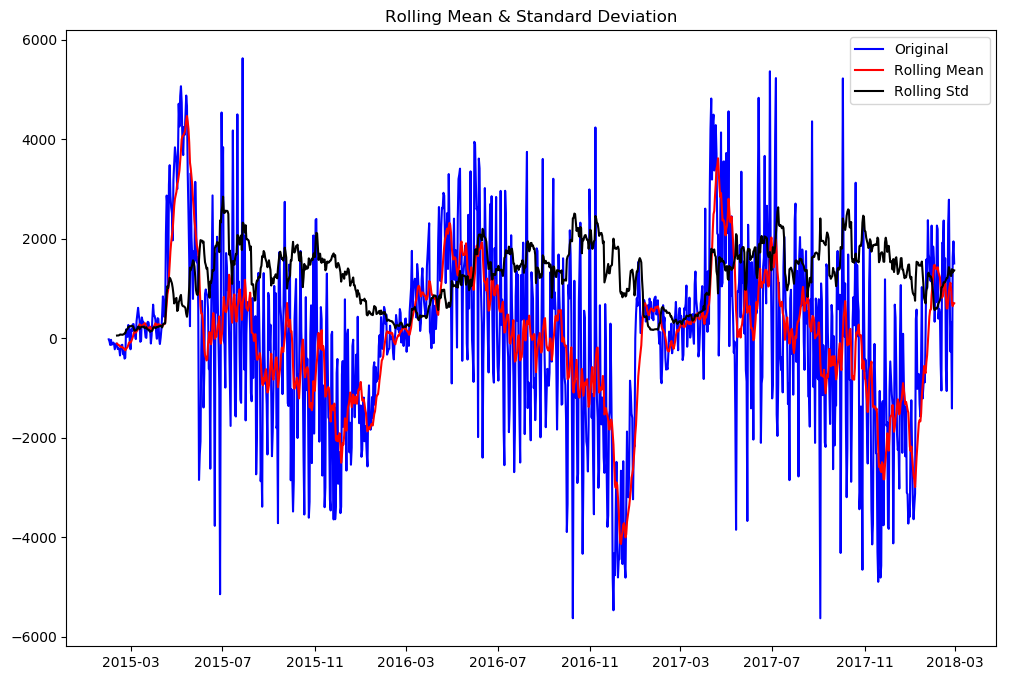

In [92]:
seasonal_difference = R_day - R_day.shift(30)
seasonal_difference
test_stationarity(seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                 -5.495922
p-value                         0.000002
#Lags Used                      9.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



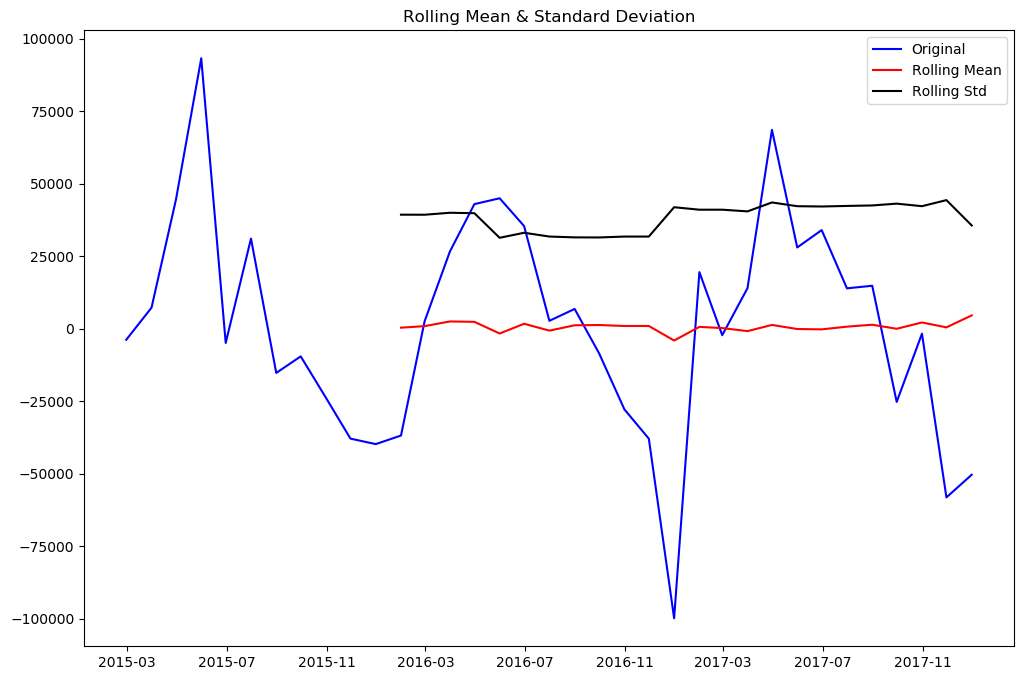

In [93]:
seasonal_difference = R_month - R_month.shift(1)
seasonal_difference
test_stationarity(seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -5.254953
p-value                          0.000007
#Lags Used                      14.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



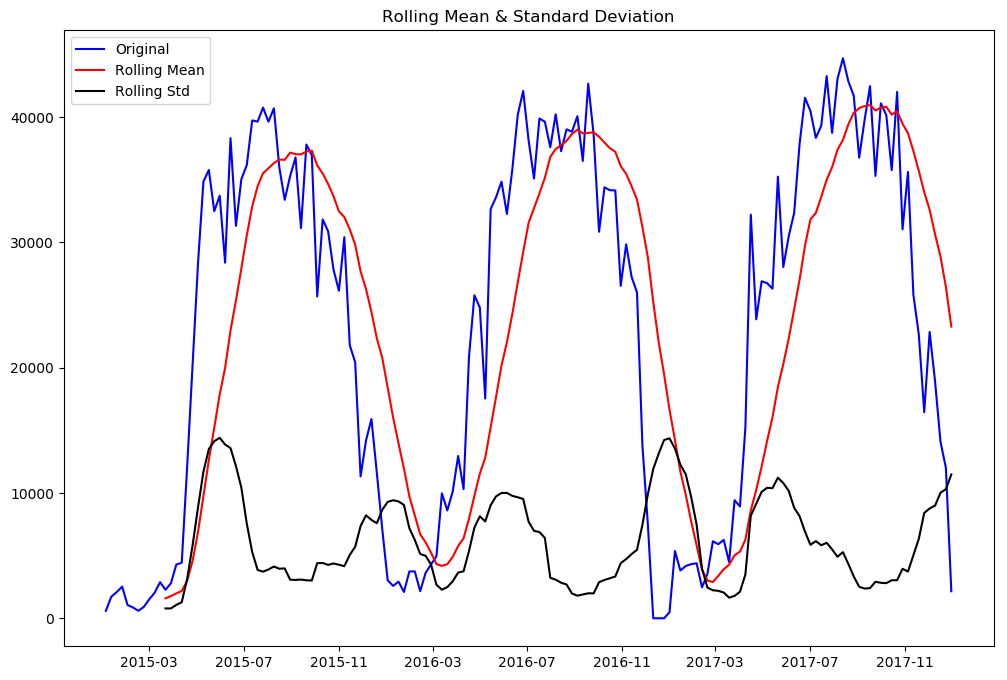

In [95]:
test_stationarity(R_week.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -5.823935e+00
p-value                        4.121196e-07
#Lags Used                     2.000000e+00
Number of Observations Used    1.530000e+02
Critical Value (1%)           -3.473830e+00
Critical Value (5%)           -2.880623e+00
Critical Value (10%)          -2.576945e+00
dtype: float64


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



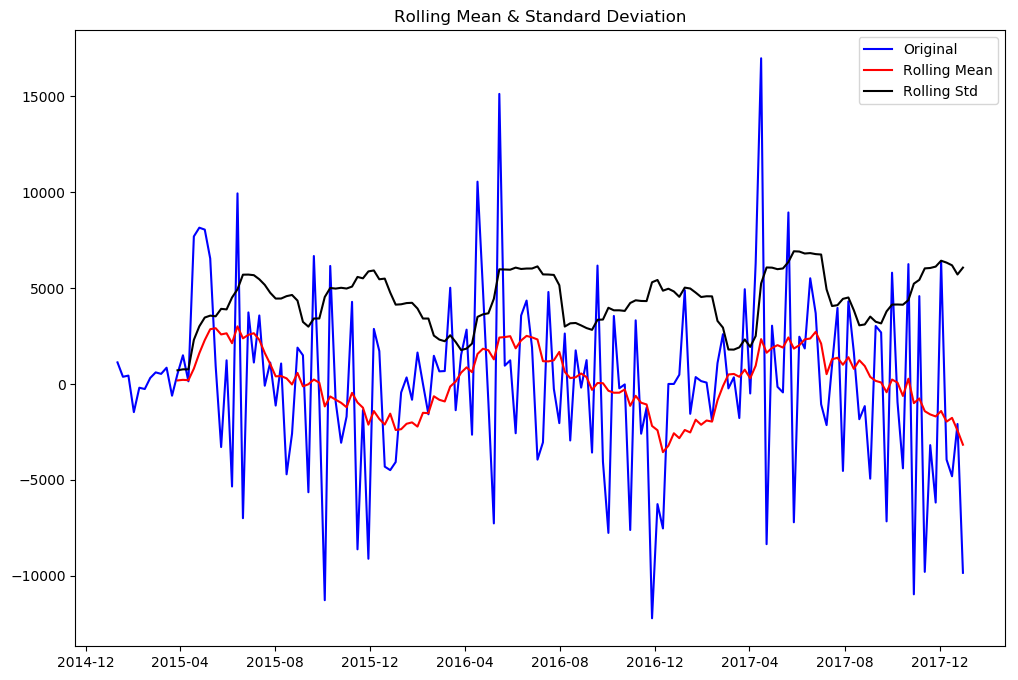

In [94]:
seasonal_difference_week = R_week - R_week.shift(1)
seasonal_difference_week
test_stationarity(seasonal_difference_week.dropna(inplace=False))

### General Seasonal Autoregressive Integrated Moving Average Model (SARIMA)
The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

### Initial SARIMA Model for day
Create an initial SARIMA model to show what model looks like without fine tunning

In [ ]:
# fit SARIMA on daily counts
# first we look at acf and pacf
import statsmodels.api as sm
sarima_day = sm.tsa.statespace.SARIMAX(R_day, order=(1,1,1), seasonal_order=(1,1,1,7), trend="c").fit()
print(sarima_day.summary())

# look at resids to find patterns and update sarima
plt.plot(sarima_day.resid, "bo")
print(plot_acf(sarima_day.resid, lags=50))
print(plot_pacf(sarima_day.resid, lags=50))

### SARIMA Model for week

In [ ]:
# fit SARIMA on weekly counts
# first we look at acf and pacf
import statsmodels.api as sm
sarima_week = sm.tsa.statespace.SARIMAX(R_week, order=(1,1,1), seasonal_order=(1,0,0,52), trend="c").fit()
print(sarima_week.summary())

plt.plot(sarima_week.resid, "bo")
print(plot_acf(sarima_week.resid, lags=52))
print(plot_pacf(sarima_week.resid, lags=52))

### SARIMA Model for Month

In [ ]:
# fit SARIMA on monthly counts
# first we look at acf and pacf
import statsmodels.api as sm
sarima_month = sm.tsa.statespace.SARIMAX(R_month, order=(0,1,1), seasonal_order=(0,0,0,12), trend="c").fit()
print(sarima_month.summary())

plt.plot(sarima_month.resid, "bo")
print(plot_acf(sarima_month.resid, lags=30))
print(plot_pacf(sarima_month.resid, lags=30))

In [ ]:
plt.subplots(figsize=(14,6))
sarima_month.predict(start=0, end=52, dynamic=36).plot()
R_month.plot()
plt.legend()

### General Forecasting

In [ ]:

#turn daily series into dataframe and add prediction column
df_day = R_day.to_frame()
df_day.rename(columns={"BikeID" : "Count"}, inplace=True)

#turn weekly series into dataframe and add prediction column
df_week = R_week.to_frame()
df_week.rename(columns={"BikeID" : "Count"}, inplace=True)

#turn monthly series into dataframe and add prediction column
df_month = R_month.to_frame()
df_month.rename(columns={"BikeID" : "Count"}, inplace=True)

In [ ]:
#plot weekly actual and forecast
df_week['Forecast'] = sarima_week.predict()  
df_week
df_week.plot(figsize=(14, 6));

In [ ]:
#plot daily actual and forecast
df_day['Forecast'] = sarima_day.predict()  
df_day
df_day.plot(figsize=(14, 6));

In [ ]:
#plot monthly actual and forecast
df_month['Forecast'] = sarima_month.predict()  
df_month.plot(figsize=(14,6));

### Show Projections into the Future

In [ ]:
df_day.head()

In [ ]:
# decompose data into trend, seasonal, and residual
decomposition = sm.tsa.seasonal_decompose(df_month.Count, model='additive')
fig = decomposition.plot()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_week.Count, model='additive')
fig = decomposition.plot()

In [ ]:
# using itertools to gridsearch solutions
import itertools

#set parameter range; UPDATE THESE!
p = q = range(0, 3)
d = range(0, 3)
season = 7

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [ ]:
# find optimal ARIMA for annual
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(R_day, order=param,
                        seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit()

            print('ARIMA{},{} - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

In [ ]:
# dynamic forecast
fcast = df_day.get_prediction(start=df_day.index.max(), dynamic=True, full_results=True)
fcast_ci = fcast.conf_int()
print(fcast_ci)
# caution: this is modeling assumptions on top of assumptions

In [ ]:
# forecast next 100 months and get confidence interval
pred_uc = co2sar.get_forecast(steps=100)

pred_ci = pred_uc.conf_int()

In [ ]:
# plot forecast
ax = co2[:].plot(label='Observed CO2 Levels')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('CO2')

plt.legend()
plt.show()

In [ ]:
#add daily dates to df_day
start = df_day.index.max()
pred_start = df_day.shape[0]
date_list = [start + relativedelta(days=x) for x in range(1,366)]
future_day = pd.DataFrame(index=date_list, columns= df_day.columns)
df_day = pd.concat([df_day, future_day])

df_day.info()

In [ ]:
pred_start

In [ ]:
# plot the data and project days into the future
df_day['Forecast'] = sarima_week.predict(start=pred_start+1, end=pred_start+15, dynamic=0) 
df_day.plot(figsize=(14, 6));

In [ ]:
#plot the last few days of data and project days into the future
df_day_recent = df_day.ix[1080:1103]
df_day_recent.plot(figsize=(14, 9));

In [ ]:
#add weekly dates to df_week
start = dt.strptime("2017-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,52)]
future_week = pd.DataFrame(index=date_list, columns= df_week.columns)
df_week = pd.concat([df_week, future_week])

df_week.info()

In [ ]:
df_week['Forecast'] = sarima_week.predict(start=0, end=190, dynamic=157)  
df_week.plot(figsize=(12, 8));

In [ ]:
365*3